In [1]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
from data import Dataloader
from models import RandomExampleModel
from models import TwoClustersMIP
import metrics

In [3]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()
X,Y = X[:1000], Y[:1000]

In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.03176032 -0.12326477]
 [-0.25515776 -0.48930476]
 [-0.08491397 -0.34554887]
 [-0.15652997 -0.13764796]
 [-0.01203235 -0.00295401]]


In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [8]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.582
Percentage of explained preferences for all samples: 0.582


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 1]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
Z = Z[:1000]
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.6348348348348348
Cluster intersection for all samples: 0.6348348348348348


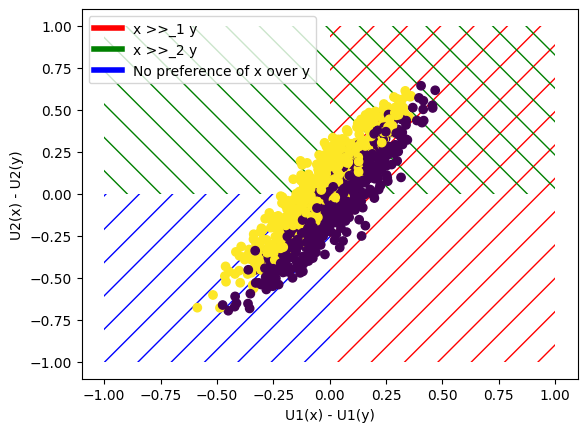

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [13]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5,"n_clusters":2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-29


In [14]:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Percentage of explained preferences on train data: 1.0
Percentage of preferences well regrouped into clusters: 1.0


In [22]:
def plot_utility_functions(u_opt):
	n_features = u_opt.shape[0]
	n_clusters = u_opt.shape[2]
	fig, axs = plt.subplots(n_clusters, n_features, figsize = (20,10), gridspec_kw={'width_ratios': [1]*n_features, 'height_ratios': [1]*n_clusters})
	for k in range(n_clusters):
		for i in range(n_features):
			axs[k,i].plot(u_opt[i, :, k])
	plt.show()

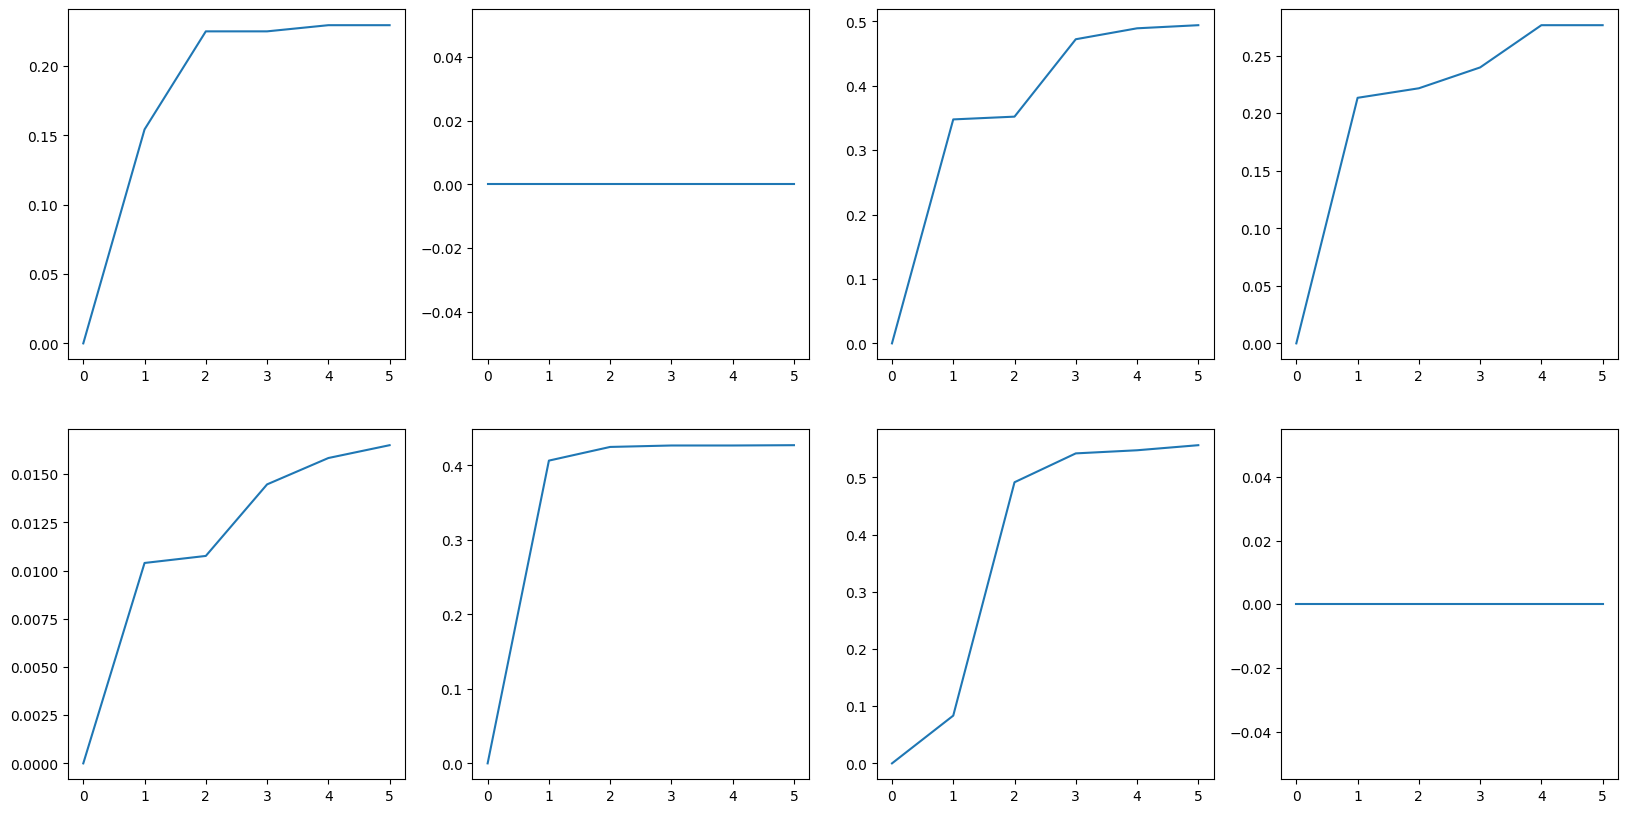

In [23]:
plot_utility_functions(model.u)

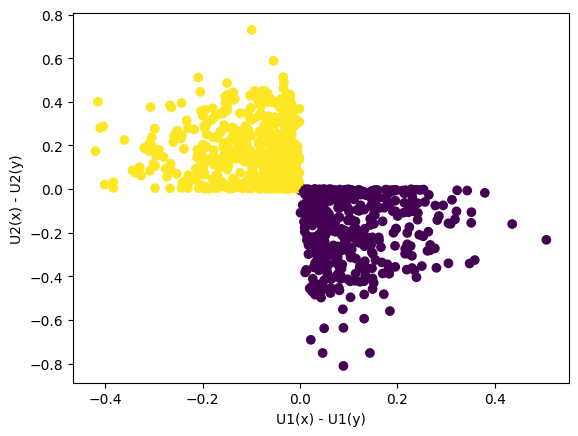

In [24]:
# As an example here are the results obtained with:
# Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()

# Here is how it should look like
# from IPython.display import Image
# Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.

In [25]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

from data import Dataloader
from models import RandomExampleModel
from models import TwoClustersMIP
import metrics

data_loader = Dataloader("../data/dataset_4") 
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()

from models import HeuristicModel

all_models_dico = {}
for version in ["difference_KMeans_L2", "difference_AHC_cosine", "concatenation_KMeans_L2", "concatenation_AHC_cosine"]:
	for n_iterations in range(1,13):
		parameters = {"n_pieces": 5,"n_clusters":2, "clustering_method":version, "n_iterations":n_iterations} 
		model = HeuristicModel(**parameters)
		model.fit(X, Y)
		all_models_dico[(version, n_iterations)] = model
		
		pairs_explained = metrics.PairsExplained()
		cluster_intersection = metrics.ClusterIntersection()
		if n_iterations == 1 or n_iterations == 12:
			print("-----------------------------------")
			print("clustering_method:", version)
			print("n_iterations:", n_iterations)
			print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) 
			print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

-----------------------------------
clustering_method: difference_KMeans_L2
n_iterations: 1
Percentage of explained preferences on train data: 0.9255
Percentage of preferences well regrouped into clusters: 0.9231615807903952


In [ ]:
def plot_results(model, X, Y, Z):
    plt.figure()
    plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
                model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
    plt.xlabel("U1(x) - U1(y)")
    plt.ylabel("U2(x) - U2(y)")
    plt.show()

In [ ]:
def plot_results_evolution(all_models_dico, X, Y, Z):
	version = "difference_KMeans_L2"
	for n_iterations in [1,2,3,12]:
		model = all_models_dico[(version, n_iterations)]
		plot_results(model, X, Y, Z)

In [ ]:
def plot_pairs_explained_evolution(all_models_dico, X, Y, Z):
	for version in ["difference_KMeans_L2", "difference_AHC_cosine", "concatenation_KMeans_L2"]:
		scores = []
		for n_iterations in range(1,13):
			model = all_models_dico[(version, n_iterations)]
			pairs_explained = metrics.PairsExplained()
			scores.append(pairs_explained.from_model(model, X, Y))
		plt.plot(range(1,13), scores, label = version)
	plt.xlabel("Number of iterations")
	plt.ylabel("Percentage of explained preferences on train data")
	plt.legend()
	plt.show()

In [ ]:
def plot_cluster_intersection_evolution(all_models_dico, X, Y, Z):
	for version in ["difference_KMeans_L2", "difference_AHC_cosine", "concatenation_KMeans_L2"]:
		scores = []
		for n_iterations in range(1,13):
			model = all_models_dico[(version, n_iterations)]
			cluster_intersection = metrics.ClusterIntersection()
			scores.append(cluster_intersection.from_model(model, X, Y, Z))
		plt.plot(range(1,13), scores, label = version)
	plt.xlabel("Number of iterations")
	plt.ylabel("Percentage of preferences well regrouped into clusters")
	plt.legend()
	plt.show()

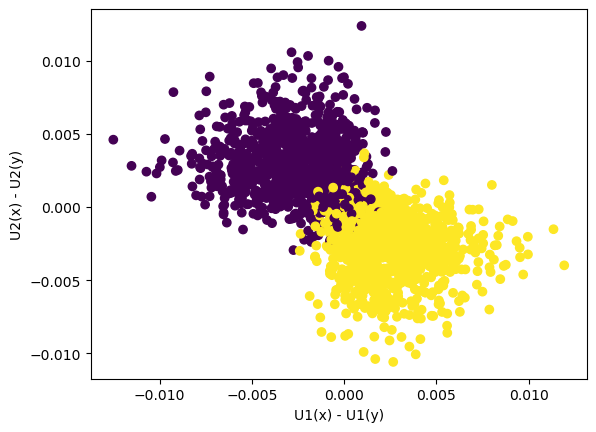

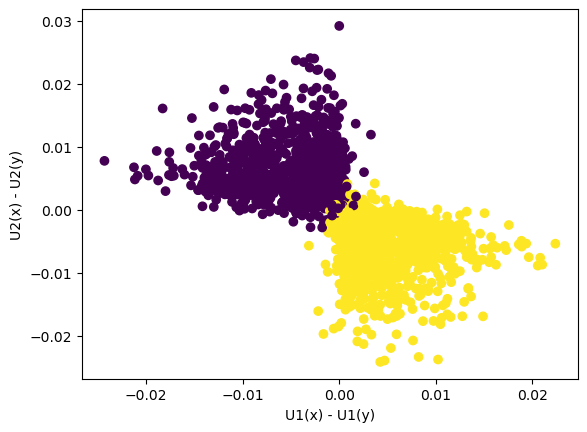

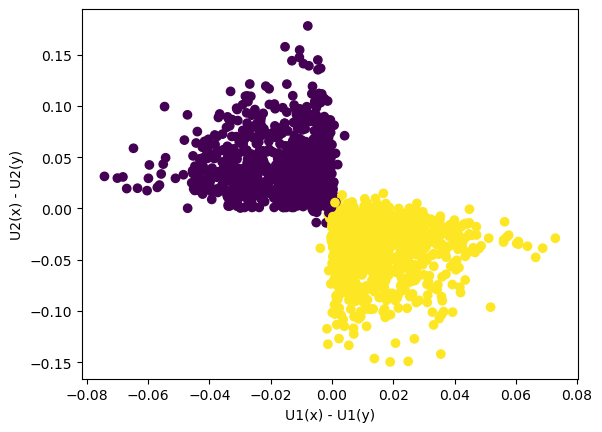

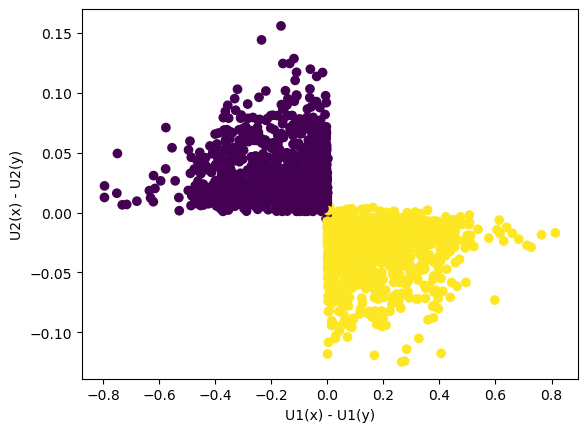

In [ ]:
plot_results_evolution(all_models_dico, X, Y, Z)

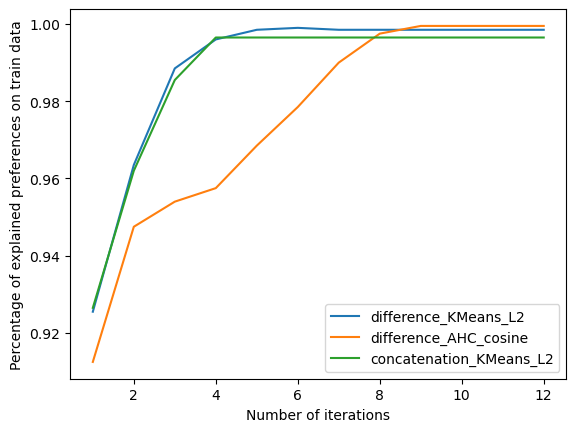

In [ ]:
plot_pairs_explained_evolution(all_models_dico, X, Y, Z)

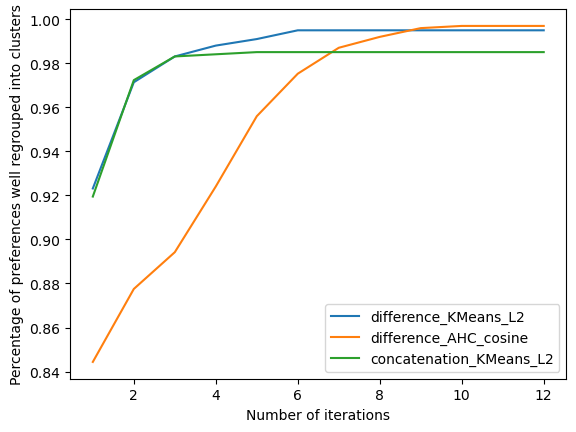

In [ ]:
plot_cluster_intersection_evolution(all_models_dico, X, Y, Z)

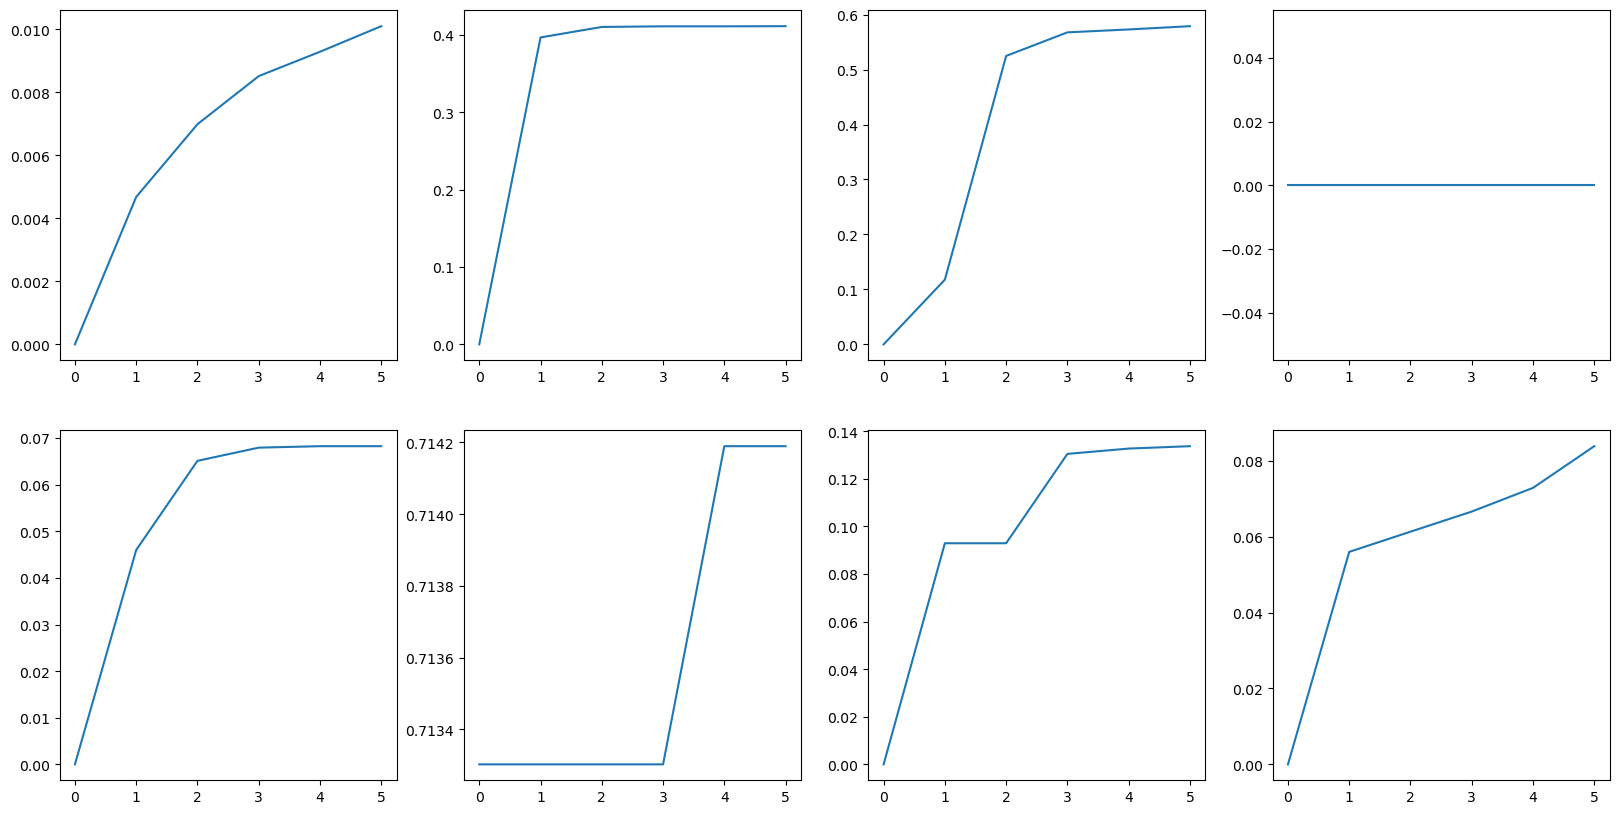

In [ ]:
model = all_models_dico[("difference_KMeans_L2", 12)]
plot_utility_functions(model.u)

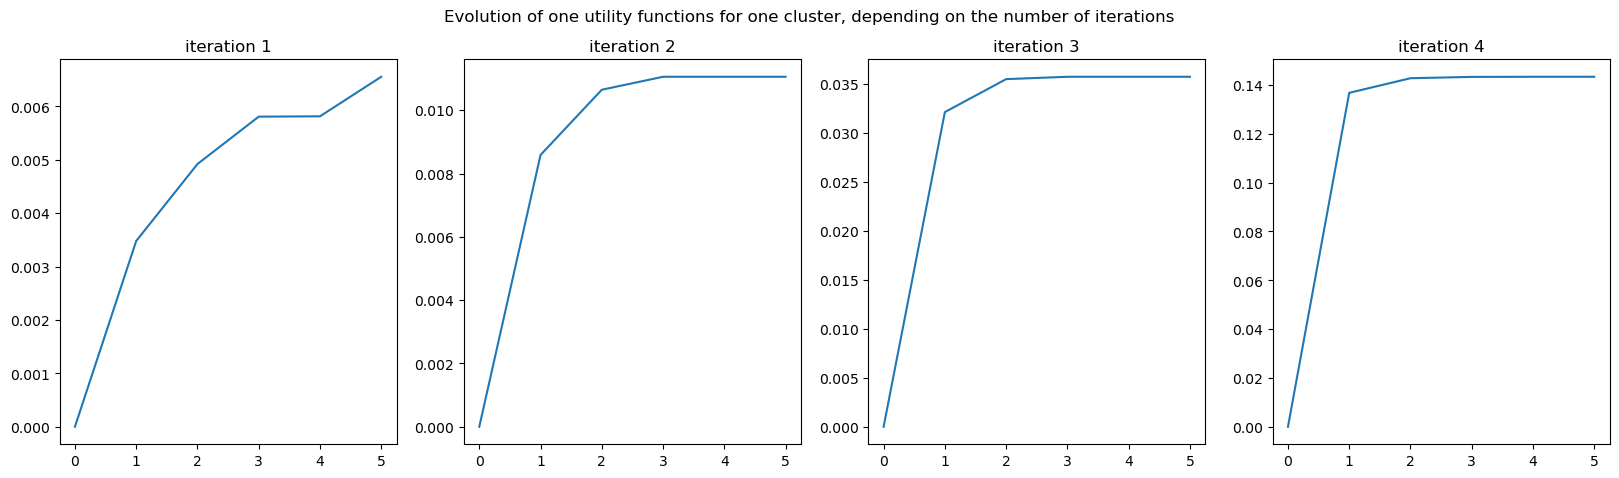

In [ ]:
def plot_utility_functions_evolution(all_models_dico):
	fig, axs = plt.subplots(1, 4, figsize = (20,5))
	# Define the title of the figure
	fig.suptitle('Evolution of one utility functions for one cluster, depending on the number of iterations')
	for i,it in enumerate([1, 2, 3, 4]):
		model = all_models_dico[("difference_KMeans_L2", it)]
		u = model.u
		axs[i].plot(u[1, :, 0])
		axs[i].set_title('iteration '+str(it))
	plt.show()

plot_utility_functions_evolution(all_models_dico)